<a href="https://colab.research.google.com/github/BPALAN-USD/AAI-502/blob/main/AAI_520_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing all the required libraries**

In [10]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import nltk
import time
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import gensim
from gensim.models import Word2Vec



In [2]:
!pip install gensim

### **Load data from CSV file into Dataframe**

In [3]:
# filename
filename_train = "BBCNewsTrain.csv.zip"   # adjust if needed

# Unzip and read CSV
with zipfile.ZipFile(filename_train, 'r') as z:
    # list files inside zip
    print("Files inside zip:", z.namelist())
    # read first file in zip into dataframe
    with z.open(z.namelist()[0]) as f:
        df_train = pd.read_csv(f)

# Preview dataset
print(df_train.head())
print("\nCategories distribution:\n", df_train['Category'].value_counts())


Files inside zip: ['BBC News Train.csv']
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

Categories distribution:
 Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


### 1. Data Exploration



1.   Display Basic Statistics
2.   Visualize Article Distribution by Category

3.   Display Sample Article by each Category.



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None

Missing values:
ArticleId    0
Text         0
Category     0
dtype: int64


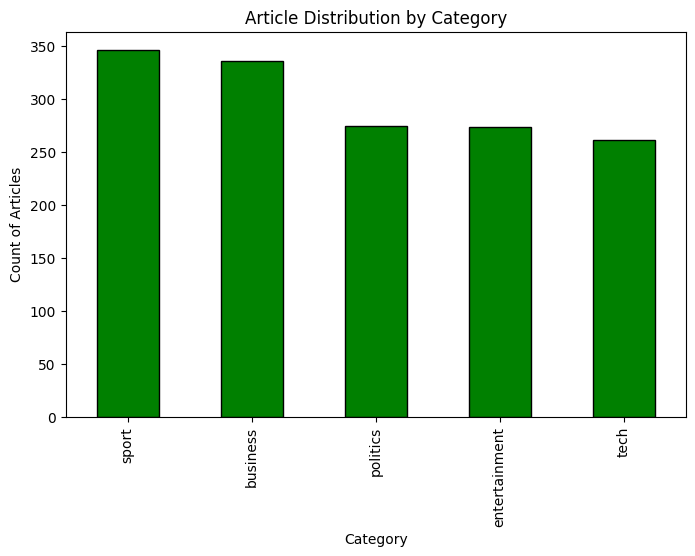

Category: business
nasdaq planning $100m share sale the owner of the technology-dominated nasdaq stock index plans to sell shares to the public and list itself on the market it operates.  according to a registration document filed with the securities and exchange commission  nasdaq stock market plans to raise $100m (£52m) from the sale. some observers see this as another step closer to a full public listing. however nasdaq  an icon of the 1990s technology boom  recently poured cold water on those suggestions.  the company first sold shares in private placements during 2000 and 2001. it technically went public in 2002 when the stock started trading on the otc bulletin board  which lists equities that trade only occasionally. nasdaq will not make money from the sale  only investors who bought shares in the private placings  the filing documents said. the nasdaq is made up shares in technology firms and other companies with high growth potential. it was the most potent symbol of the 1990s

In [4]:
# 1. Display Basic Statistics
print("\nDataset Info:")
print(df_train.info())
#print("\nCategory Distribution:")
#print(df_train['Category'].value_counts())
print("\nMissing values:")
print(df_train.isnull().sum())

# 2. Visualize Article Distribution by Category
plt.figure(figsize=(8,5))
df_train['Category'].value_counts().plot(kind='bar', color='green', edgecolor='black')
plt.title("Article Distribution by Category")
plt.xlabel("Category")
plt.ylabel("Count of Articles")
#plt.xticks(rotation=45)
plt.show()

# 3. Display sample articles from each category
for category in df_train['Category'].unique():
    print("="*80)
    print(f"Category: {category}")
    sample_text = df_train[df_train['Category'] == category].sample(1, random_state=42)['Text'].values[0]
    print(sample_text)  # show first 500 chars for readability

### 2. Text Pre-Processing

Create and compare 2 preprocessing pipelines:


1.   Basic: tokenization + lowercasing + stop word removal
2.   Advanced: Basic + stemming + lemmatization + POS filtering. Compare vocabulary size and processing time for both approaches..


In [5]:
# Download resources if not already
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")



stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [6]:
## Pre-Process Basic Pipeline
def preprocess_basic_pipeline(text):
    tokens = word_tokenize(text.lower()) ## Tokenize + Lowercasing
    return [w for w in tokens if w.isalpha() and w not in stop_words] ## Stop Words removal

## This we need because
## WordNetLemmatizer POS tags in a different format ('n', 'v', 'a', 'r'),
## while pos_tag outputs Penn Treebank tags (NN, VB, JJ, RB etc.).

def get_wordnet_pos(tag):
    """Map POS tag to WordNet POS for lemmatizer"""
    if tag.startswith("J"):
        return "a"  # adjective
    elif tag.startswith("V"):
        return "v"  # verb
    elif tag.startswith("N"):
        return "n"  # noun
    elif tag.startswith("R"):
        return "r"  # adverb
    else:
        return None

## Pre-Process Advance Pipeline
def preprocess_advanced_pipeline(text):
    tokens = word_tokenize(text.lower())
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words]

    # POS tagging
    pos_tags = pos_tag(tokens)

    processed = []
    for word, tag in pos_tags:
        wn_pos = get_wordnet_pos(tag)
        if wn_pos:  # keep only selected POS
            lemma = lemmatizer.lemmatize(word, pos=wn_pos)
            stemmed = stemmer.stem(lemma)
            processed.append(stemmed)
    return processed


In [7]:
# BASIC
start = time.time()
basic_tokens = df_train["Text"].apply(preprocess_basic_pipeline)
basic_vocab = set([w for tokens in basic_tokens for w in tokens])
basic_time = time.time() - start

# ADVANCED
start = time.time()
adv_tokens = df_train["Text"].apply(preprocess_advanced_pipeline)
adv_vocab = set([w for tokens in adv_tokens for w in tokens])
adv_time = time.time() - start

# Comparison results
print("===== Comparison =====")
print(f"Basic vocab size:     {len(basic_vocab)}")
print(f"Advanced vocab size:  {len(adv_vocab)}")
print(f"Basic processing time: {basic_time:.2f} sec")
print(f"Advanced processing time: {adv_time:.2f} sec")


===== Comparison =====
Basic vocab size:     22996
Advanced vocab size:  15457
Basic processing time: 4.46 sec
Advanced processing time: 31.79 sec


### 3. Text Vectorization

Implement and compare:
- Bag of Words (CountVectorizer)
- TF-IDF (TfidfVectorizer)
- Word2Vec (both CBoW and Skip-gram, average word vectors for documents). Create visualizations comparing the methods.

In [8]:
## Combine tokens to a doc
docs_advance = adv_tokens.apply(lambda x: " ".join(x))

## Bag of Words
cv = CountVectorizer()
bow_matrix = cv.fit_transform(docs_advance)

print("Bag of Words shape:", bow_matrix.shape)

## TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(docs_advance)

print("TF-IDF shape:", tfidf_matrix.shape)



Bag of Words shape: (1490, 15437)
TF-IDF shape: (1490, 15437)


In [11]:
## Prepare data as list of token lists
sentences = adv_tokens.tolist()

## CBOW model
w2v_cbow = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)

## Skip-gram model
w2v_sg = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)


def get_doc_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# CBOW document vectors
doc_vec_cbow = np.array([get_doc_vector(doc, w2v_cbow) for doc in sentences])
# Skip-gram document vectors
doc_vec_sg = np.array([get_doc_vector(doc, w2v_sg) for doc in sentences])

print("CBOW doc vector shape:", doc_vec_cbow.shape)
print("Skip-gram doc vector shape:", doc_vec_sg.shape)

CBOW doc vector shape: (1490, 100)
Skip-gram doc vector shape: (1490, 100)


In [12]:
methods = {
    "Bag of Words": bow_matrix.shape,
    "TF-IDF": tfidf_matrix.shape,
    "Word2Vec CBOW": doc_vec_cbow.shape,
    "Word2Vec Skip-gram": doc_vec_sg.shape
}

print("Method comparison (rows = docs, cols = features/vector size):")
for k,v in methods.items():
    print(f"{k}: {v}")

Method comparison (rows = docs, cols = features/vector size):
Bag of Words: (1490, 15437)
TF-IDF: (1490, 15437)
Word2Vec CBOW: (1490, 100)
Word2Vec Skip-gram: (1490, 100)


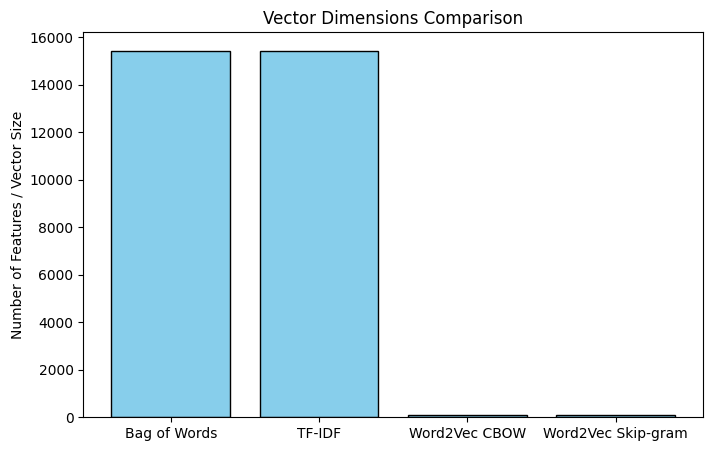

In [13]:
import matplotlib.pyplot as plt

names = list(methods.keys())
values = [v[1] for v in methods.values()]

plt.figure(figsize=(8,5))
plt.bar(names, values, color="skyblue", edgecolor="black")
plt.title("Vector Dimensions Comparison")
plt.ylabel("Number of Features / Vector Size")
plt.show()


### 4. Classification

For each vectorization method, train:
- Logistic Regression
- Simple LSTM




In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode categories as numbers
label_enc = LabelEncoder()
y = label_enc.fit_transform(df_train["Category"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(docs_advance, y, test_size=0.2, random_state=42, stratify=y)


In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# --- Bag of Words ---
cv = CountVectorizer()
X_train_bow = cv.fit_transform(X_train)
X_test_bow = cv.transform(X_test)

logreg_bow = LogisticRegression(max_iter=1000)
logreg_bow.fit(X_train_bow, y_train)
y_pred_bow = logreg_bow.predict(X_test_bow)

print("Logistic Regression (BoW):")
print(classification_report(y_test, y_pred_bow, target_names=label_enc.classes_))

# --- TF-IDF ---
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

logreg_tfidf = LogisticRegression(max_iter=1000)
logreg_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

print("Logistic Regression (TF-IDF):")
print(classification_report(y_test, y_pred_tfidf, target_names=label_enc.classes_))


Logistic Regression (BoW):
               precision    recall  f1-score   support

     business       0.93      0.99      0.96        67
entertainment       0.93      1.00      0.96        55
     politics       0.98      0.93      0.95        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.85      0.90        52

     accuracy                           0.96       298
    macro avg       0.96      0.95      0.95       298
 weighted avg       0.96      0.96      0.96       298

Logistic Regression (TF-IDF):
               precision    recall  f1-score   support

     business       0.92      0.99      0.95        67
entertainment       0.95      1.00      0.97        55
     politics       0.98      0.89      0.93        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.88      0.92        52

     accuracy                           0.96       298
    macro avg       0.96      0.95      0.95       298
 we

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = max(len(seq) for seq in X_train_seq)  # or set fixed (e.g., 200)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1


In [20]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(len(label_enc.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=2, batch_size=32, verbose=1
)

loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM Test Accuracy: {acc:.3f}")


Epoch 1/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.2157 - loss: 1.6091 - val_accuracy: 0.2594 - val_loss: 1.6048
Epoch 2/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.2425 - loss: 1.6042 - val_accuracy: 0.1841 - val_loss: 1.6068
LSTM Test Accuracy: 0.225


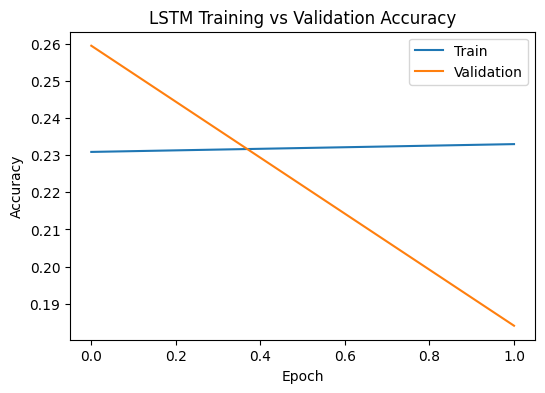

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("LSTM Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
